In [72]:
from netCDF4 import Dataset
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as crs
from wrf import get_cartopy, getvar, latlon_coords, to_np, extract_times, ALL_TIMES
import os, sys

is_py = os.path.basename(sys.argv[0]) == 'bdy-height-vid-multi.ju.py'
URB_AREA_SIZES = [10, 20, 40, 60, 80]

root_dir = '/home/guc/'
data_dir = 'tmp/'
image_dir = glob(root_dir + data_dir)[0]

template_dataset = Dataset(glob(f'/home/guc/runs/*ahe-100-rnd-wind/wrfout*')[0])
template_var = getvar(template_dataset, "PBLH", timeidx=0)
column_size = len(URB_AREA_SIZES)

In [106]:
def plot_image(debug: bool = False) -> None:
    times = extract_times(template_dataset, timeidx=ALL_TIMES)
    urban_scaled_size = 80
    default_padding_size = (100 - urban_scaled_size) // 2

    z_data = getvar(template_dataset, "z", timeidx=0)
    lats, lons = latlon_coords(z_data)
    cart_proj = get_cartopy(z_data)
    plot_lim = np.linspace(0, 3000, 21)
    
    if debug: times = times[120:121]

    for time_idx, datetime in enumerate(times):
        fig, axes = plt.subplots(1, column_size, figsize=(20, 3), subplot_kw={'projection': cart_proj})
        for i, urb_size in enumerate(URB_AREA_SIZES):
            print(f'Processing URB_SIZE={urb_size}, {datetime}', end='\r')

            if urb_size == 20:
                file_name = glob(f'/home/guc/runs/*-urban-grassland-ahe-100-rnd-wind/wrfout*')[0]
            else:
                file_name = glob(f'/home/guc/runs/*-urban-grassland-ahe-100-urban-{urb_size}/wrfout*')[0]

            dataset = Dataset(file_name)
            pixel_scale = urban_scaled_size / urb_size # Scale the map up to 80*80 urban area size
            padding_size = default_padding_size // pixel_scale

            mask_x = slice(int(50 - ((urb_size // 2) + padding_size)), int(50 + ((urb_size // 2) + padding_size)), None)
            mask_y = slice(int(50 - ((urb_size // 2) + padding_size)), int(50 + ((urb_size // 2) + padding_size)), None)
            var_data = getvar(dataset, "PBLH", timeidx=time_idx)

            gridlines = axes[i].gridlines(
                crs=crs.PlateCarree(),
                draw_labels=True,
                x_inline=False,
                y_inline=False,
                linewidth=0.1,
                color="black",
                linestyle="dotted",
            )
            gridlines.top_labels = None
            gridlines.right_labels = None

            plt.contourf(lons, lats, to_np(var_data), plot_lim, cmap="Spectral_r", transform=crs.PlateCarree())

            contour = axes[i].contourf(
                to_np(lons)[mask_x, mask_y],
                to_np(lats)[mask_x, mask_y],
                var_data[mask_x, mask_y],
                plot_lim,
                cmap="Spectral_r",
                extend='max',
                transform=crs.PlateCarree()
            )

            axes[i].set_title(f'SIZE = {urb_size}', y=-0.15)

            axes[i].grid(linewidth=0.1)

            if i == column_size - 1:
                fig.subplots_adjust(right=0.8)
                cbar_ax = fig.add_axes((0.825, 0.125, 0.01, 0.75))
                cbar = fig.colorbar(contour, cax=cbar_ax, ticks=plot_lim[::5])
                cbar.ax.set_ylabel('Height (m)')

        if not debug:
            output_name = image_dir + np.datetime_as_string(datetime, unit='s') + '.png'
            plt.savefig(output_name)
            plt.clf()
            plt.close()

Starting visualization for bdy-height-vid-multi
(12, 12)ng URB_SIZE=10, 2025-03-10T06:00:00.000000000
(12, 12)
(24, 24)ng URB_SIZE=20, 2025-03-10T06:00:00.000000000
(24, 24)
(50, 50)ng URB_SIZE=40, 2025-03-10T06:00:00.000000000
(50, 50)
(74, 74)ng URB_SIZE=60, 2025-03-10T06:00:00.000000000
(74, 74)
(99, 99)ng URB_SIZE=80, 2025-03-10T06:00:00.000000000
(99, 99)


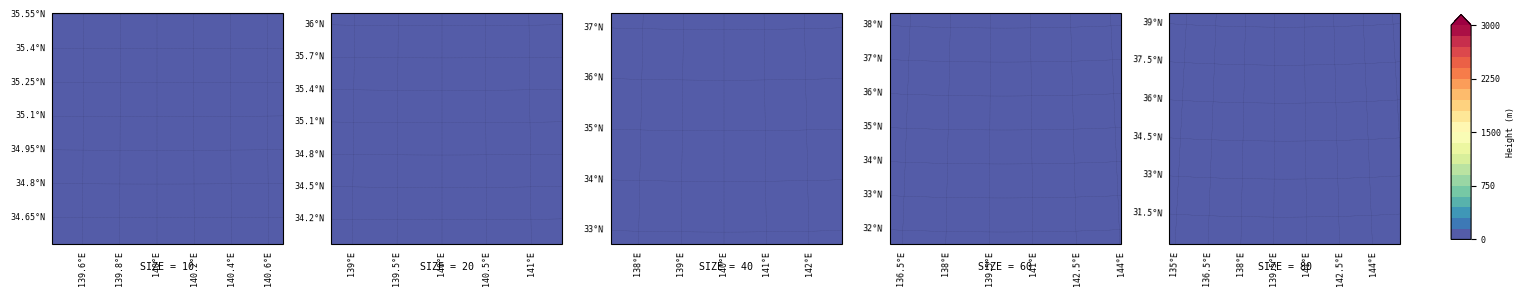

In [107]:
plt.rcParams["font.family"] = "DejaVu Sans Mono"
plt.rcParams["font.size"] = 6

import subprocess
print(f'Starting visualization for bdy-height-vid-multi')
plot_image(not is_py)

# Call ffmpeg to create video
if is_py:
    subprocess.call(['/home/guc/scripts/visualize/generate-video.sh', f'{RUN_ID:03}'])
    subprocess.call(['mv', 'out.mp4', root_dir + f'results/{RUN_ID:03}-{len(glob(root_dir + f'results/{RUN_ID:03}*.mp4')) + 1}.mp4'])
    for image_name in glob(image_dir + '*.png'):
        os.remove(image_name)
    print('Done!!')